In [6]:
import csv
import os
import pickle
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE

from PIL import Image

from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import vgg16, inception_v3, resnet, xception
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, GlobalAveragePooling2D, MaxPooling2D
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier

In [7]:
RANDOM_STATE = 42

In [9]:
def load_dataset(target_size):
    x, y = [], []
    base_path = "./data/images/"

    for dir in os.listdir(base_path):
        for image in os.listdir(os.path.join(base_path, dir)):
            image_path = os.path.join(base_path, dir, image)
            image = Image.open(image_path)
            rgb_image = image.copy().convert("RGB")
            x.append(np.array(rgb_image.resize(target_size), dtype=np.uint8))
            y.append(dir)

    return x, y

In [10]:
target_size = (224, 224)

In [11]:
metadata = pd.read_csv("./data/metadata.csv")
meta_filter = metadata[["Channel", "Category"]]
meta_filter = meta_filter.drop_duplicates()
meta_dict = meta_filter.set_index("Channel")["Category"].to_dict()

In [12]:
x, y = load_dataset(target_size)

class: Abroad in Japan


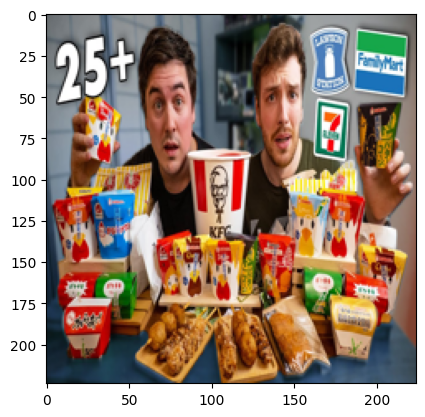

In [13]:
plt.imshow(x[100])
print(f"class: {y[100]}")

In [14]:
y = [meta_dict[item] for item in y]
le = LabelEncoder()
y_encoded = le.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

In [15]:
set_y = set(y)
count_dict = {}
for item in set_y:
    count_dict[item] = y.count(item)

In [16]:
print(count_dict)

{'Automobile': 188, 'Blog,Entertainment': 29, 'Comedy': 30, 'VideoGames': 253, 'Blog,Comedy': 50, 'Blog,Science': 27, 'Food': 213, 'Tech,Comedy': 28, 'Automobile,Comedy': 73, 'Tech,News': 27, 'Tech': 176, 'Entertainment,Comedy': 83, 'Entertainment': 51, 'Food,Entertainment': 25, 'Tech,Informative': 29, 'Comedy,Entertainment': 88, 'News': 193, 'Blog': 128, 'Comedy,Informative': 56, 'Science': 252, 'Entertainment,Blog': 30, 'Informative': 215}


In [17]:
with open("./results/Data/CSV/distribution_v1.csv", "w", newline='') as f:
    writer = csv.writer(f)
    writer.writerow(["Category", "Count"])
    for category, occurence in count_dict.items():
        writer.writerow([category, occurence])

In [18]:
with open('le_classes.pkl', 'wb') as f:
    pickle.dump(le.classes_, f)

In [19]:
sm = SMOTE(random_state=RANDOM_STATE)
x = np.array(x)
n_samples, width, height, n_channels = x.shape

x_flat = x.reshape(n_samples, -1)

x, y_one_hot = sm.fit_resample(x_flat, y_one_hot)
x = x.reshape(-1, width, height, n_channels)

In [20]:
x_train, x_test, y_train, y_test = train_test_split(x, y_one_hot, test_size=0.2, random_state=RANDOM_STATE)
x_train = np.array(x_train)
x_test = np.array(x_test)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=RANDOM_STATE)
x_train = np.array(x_train)
x_val = np.array(x_val)

print(f"Train size: {len(y_train)} --- Validation size: {len(y_val)} --- Test size: {len(y_test)}")

Train size: 3561 --- Validation size: 891 --- Test size: 1114


In [40]:
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)

val_datagen = ImageDataGenerator(rescale=1.0/255)

In [42]:
train_generator = train_datagen.flow(
    x_train,
    y_train, 
    batch_size=32,
    shuffle=True
)

val_generator = val_datagen.flow(
    x_val,
    y_val,
    batch_size=32,
    shuffle=False
)

# Grid Search for Transfer Learning Models

In [82]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

## VGG16

In [83]:
def create_vgg16_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = vgg16.VGG16(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [85]:
model = KerasClassifier(build_fn=create_vgg16_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/20
31/31 [==============================] - 2s 52ms/step - loss: 2.2139 - accuracy: 0.1232 - val_loss: 0.5908 - val_accuracy: 0.2168 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 1s 46ms/step - loss: 0.4196 - accuracy: 0.3391 - val_loss: 0.3529 - val_accuracy: 0.2141 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 1s 47ms/step - loss: 0.2485 - accuracy: 0.4725 - val_loss: 0.3108 - val_accuracy: 0.2276 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 1s 47ms/step - loss: 0.1667 - accuracy: 0.5193 - val_loss: 0.2553 - val_accuracy: 0.2547 - lr: 0.0010
Epoch 5/20
31/31 [==============================] - 1s 46ms/step - loss: 0.1421 - accuracy: 0.5244 - val_loss: 0.2580 - val_accuracy: 0.3550 - lr: 0.0010
Epoch 6/20
31/31 [==============================] - 1s 48ms/step - loss: 0.1203 - accuracy: 0.6222 - val_loss: 0.2237 - val_accuracy: 0.3388 - lr: 0.0010
Epoch 7/20
31/3

## InceptionV3

In [89]:
def create_inceptionv3_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = inception_v3.InceptionV3(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [90]:
model = KerasClassifier(build_fn=create_inceptionv3_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Fitting 3 folds for each of 32 candidates, totalling 96 fits
Epoch 1/20
31/31 [==============================] - 5s 89ms/step - loss: 12.5501 - accuracy: 0.0886 - val_loss: 4.3645 - val_accuracy: 0.1057 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 1s 46ms/step - loss: 4.3402 - accuracy: 0.1059 - val_loss: 4.0687 - val_accuracy: 0.1165 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 1s 46ms/step - loss: 2.6693 - accuracy: 0.1314 - val_loss: 1.8285 - val_accuracy: 0.0867 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 1s 46ms/step - loss: 3.0600 - accuracy: 0.1293 - val_loss: 1.6413 - val_accuracy: 0.0949 - lr: 0.0010
Epoch 5/20
31/31 [==============================] - 1s 42ms/step - loss: 2.0644 - accuracy: 0.1507 - val_loss: 1.7302 - val_accuracy: 0.0407 - lr: 0.0010
Epoch 6/20
31/31 [==============================] - 1s 42ms/step - loss: 2.4299 - accuracy: 0.1039 - val_loss: 1.8738 - val_accuracy: 0.1057 - lr: 0.0010
Epoch 7/20
31/

## ResNet50

In [91]:
def create_resnet50_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = resnet.ResNet50(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [92]:
model = KerasClassifier(build_fn=create_resnet50_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Epoch 1/20
31/31 [==============================] - 4s 81ms/step - loss: 1.7669 - accuracy: 0.1008 - val_loss: 0.3934 - val_accuracy: 0.2656 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 2s 50ms/step - loss: 0.4494 - accuracy: 0.3625 - val_loss: 0.3228 - val_accuracy: 0.3577 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 1s 47ms/step - loss: 0.2385 - accuracy: 0.5692 - val_loss: 0.3507 - val_accuracy: 0.3469 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 1s 47ms/step - loss: 0.1411 - accuracy: 0.7281 - val_loss: 0.3577 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 5/20
31/31 [==============================] - 1s 47ms/step - loss: 0.1022 - accuracy: 0.8136 - val_loss: 0.4385 - val_accuracy: 0.3144 - lr: 0.0010
Epoch 6/20
31/31 [==============================] - 2s 51ms/step - loss: 0.0848 - accuracy: 0.8605 - val_loss: 0.3170 - val_accuracy: 0.4932 - lr: 0.0010
Epoch 7/20
31/31 [==============================] - 1s 47ms/step - loss: 0.0

## Xception

In [93]:
def create_xception_model(optimizer, init, n_hidden_1, n_hidden_2, activation):
    base_model = xception.Xception(weights="imagenet", include_top=False, input_shape=target_size+(3,))

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(n_hidden_1, activation="relu", kernel_initializer=init))
    model.add(Dense(n_hidden_2, activation="relu", kernel_initializer=init))
    model.add(Dense(len(le.classes_), activation=activation, kernel_initializer=init))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

    return model

In [94]:
model = KerasClassifier(build_fn=create_xception_model)

param_grid = {
    'optimizer': ['rmsprop', 'adam'],
    'init': ['glorot_uniform', 'normal'],
    'n_hidden_1': [64, 128],
    'n_hidden_2': [64, 128],
    'activation': ['sigmoid', 'softmax'],
}

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

Fitting 3 folds for each of 32 candidates, totalling 96 fits


c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Epoch 1/20
31/31 [==============================] - 4s 95ms/step - loss: 5.7279 - accuracy: 0.0937 - val_loss: 3.1611 - val_accuracy: 0.1084 - lr: 0.0010
Epoch 2/20
31/31 [==============================] - 2s 65ms/step - loss: 2.3667 - accuracy: 0.1670 - val_loss: 1.8171 - val_accuracy: 0.1680 - lr: 0.0010
Epoch 3/20
31/31 [==============================] - 2s 61ms/step - loss: 1.6720 - accuracy: 0.2322 - val_loss: 2.7694 - val_accuracy: 0.1680 - lr: 0.0010
Epoch 4/20
31/31 [==============================] - 2s 66ms/step - loss: 1.2845 - accuracy: 0.2281 - val_loss: 1.1784 - val_accuracy: 0.1463 - lr: 0.0010
Epoch 5/20
31/31 [==============================] - 2s 62ms/step - loss: 1.0054 - accuracy: 0.2658 - val_loss: 1.2561 - val_accuracy: 0.1491 - lr: 0.0010
Epoch 6/20
31/31 [==============================] - 2s 64ms/step - loss: 0.8491 - accuracy: 0.2617 - val_loss: 1.0978 - val_accuracy: 0.1355 - lr: 0.0010
Epoch 7/20
31/31 [==============================] - 2s 65ms/step - loss: 0.7

# Transfer Learning

## Best Parameters:
VGG16: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 64, 'optimizer': 'rmsprop'} acc: 0.44  
InceptionV3: {'activation': 'softmax', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 128, 'optimizer': 'adam'} 0.26  
ResNet50: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 128, 'optimizer': 'adam'} 0.47  
XCeption: {'activation': 'sigmoid', 'init': 'glorot_uniform', 'n_hidden_1': 128, 'n_hidden_2': 128, 'optimizer': 'adam'} 0.27  

In [98]:
model_vgg_16 = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=target_size+(3,))
model_inception_v3 = inception_v3.InceptionV3(weights='imagenet', include_top=False, input_shape=target_size+(3,))
model_resnet_50 = resnet.ResNet50(weights='imagenet', include_top=False, input_shape=target_size+(3,))
model_xception = xception.Xception(weights='imagenet', include_top=False, input_shape=target_size+(3,))

In [99]:
model_dict = {
    'vgg_16': model_vgg_16,
    'inception_v3': model_inception_v3,
    'resnet_50': model_resnet_50,
    'xception': model_xception
}

for key, value in model_dict.items():
    for layer in value.layers:
        layer.trainable = False

In [100]:
dropout = 0.2
learning_rate = 1e-03
epochs = 20

In [104]:
for key, value in model_dict.items():
    model = Sequential()
    model.add(value)
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    if key == 'vgg_16':
        model.add(Dense(64, activation="relu"))
    else:
        model.add(Dense(128, activation="relu"))
    if key == 'inception_v3':
        model.add(Dense(len(le.classes_), activation="softmax"))
    else:
        model.add(Dense(len(le.classes_), activation="sigmoid"))
    model_dict[key] = model

Epoch 1/20
47/47 [==============================] - 10s 193ms/step - loss: 2.6744 - accuracy: 0.1989 - val_loss: 2.4703 - val_accuracy: 0.3252 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 9s 191ms/step - loss: 2.2072 - accuracy: 0.3618 - val_loss: 2.3422 - val_accuracy: 0.2873 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 9s 191ms/step - loss: 1.9906 - accuracy: 0.4250 - val_loss: 2.1687 - val_accuracy: 0.3496 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 9s 193ms/step - loss: 1.7995 - accuracy: 0.4562 - val_loss: 2.1184 - val_accuracy: 0.3930 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 9s 191ms/step - loss: 1.6087 - accuracy: 0.5146 - val_loss: 2.0777 - val_accuracy: 0.3821 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 9s 190ms/step - loss: 1.5320 - accuracy: 0.5289 - val_loss: 2.1115 - val_accuracy: 0.4092 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 9s 190ms/step - l

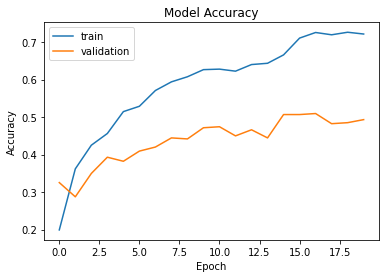

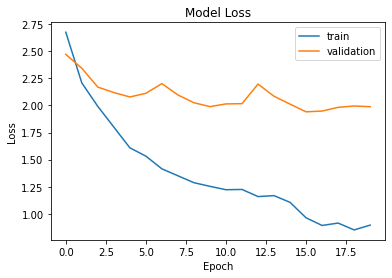

Epoch 1/20
47/47 [==============================] - 13s 228ms/step - loss: 2.9015 - accuracy: 0.1297 - val_loss: 2.6964 - val_accuracy: 0.1599 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 9s 192ms/step - loss: 2.5947 - accuracy: 0.1989 - val_loss: 2.5387 - val_accuracy: 0.2466 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 9s 193ms/step - loss: 2.4931 - accuracy: 0.2240 - val_loss: 2.4389 - val_accuracy: 0.2818 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 9s 192ms/step - loss: 2.4349 - accuracy: 0.2349 - val_loss: 2.4168 - val_accuracy: 0.2385 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 9s 193ms/step - loss: 2.4573 - accuracy: 0.2159 - val_loss: 2.3666 - val_accuracy: 0.2764 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 9s 191ms/step - loss: 2.4239 - accuracy: 0.2247 - val_loss: 2.3716 - val_accuracy: 0.2737 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 9s 189ms/step - l

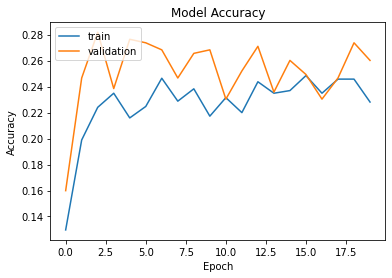

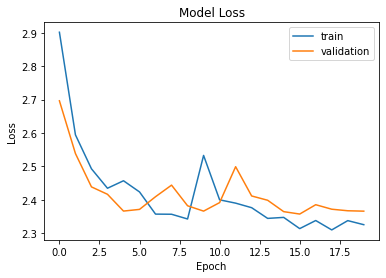

Epoch 1/20
47/47 [==============================] - 11s 205ms/step - loss: 2.8290 - accuracy: 0.1120 - val_loss: 2.8135 - val_accuracy: 0.0976 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 9s 193ms/step - loss: 2.7630 - accuracy: 0.1025 - val_loss: 2.8197 - val_accuracy: 0.1003 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 9s 192ms/step - loss: 2.7623 - accuracy: 0.1113 - val_loss: 2.8183 - val_accuracy: 0.1328 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 9s 191ms/step - loss: 2.7668 - accuracy: 0.1032 - val_loss: 2.8309 - val_accuracy: 0.1003 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 9s 193ms/step - loss: 2.7652 - accuracy: 0.1127 - val_loss: 2.8195 - val_accuracy: 0.0949 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 9s 192ms/step - loss: 2.7593 - accuracy: 0.0937 - val_loss: 2.8302 - val_accuracy: 0.1003 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 9s 193ms/step - l

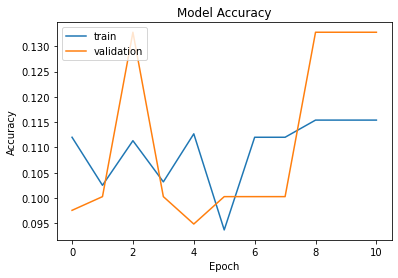

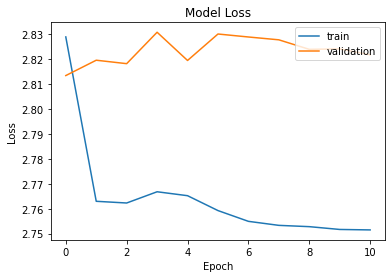

Epoch 1/20
47/47 [==============================] - 11s 214ms/step - loss: 2.6446 - accuracy: 0.2451 - val_loss: 2.4101 - val_accuracy: 0.2981 - lr: 0.0010
Epoch 2/20
47/47 [==============================] - 9s 193ms/step - loss: 2.1659 - accuracy: 0.3659 - val_loss: 2.2367 - val_accuracy: 0.3577 - lr: 0.0010
Epoch 3/20
47/47 [==============================] - 9s 191ms/step - loss: 2.0072 - accuracy: 0.4277 - val_loss: 2.1808 - val_accuracy: 0.3875 - lr: 0.0010
Epoch 4/20
47/47 [==============================] - 9s 190ms/step - loss: 1.9282 - accuracy: 0.4318 - val_loss: 2.2253 - val_accuracy: 0.3821 - lr: 0.0010
Epoch 5/20
47/47 [==============================] - 9s 190ms/step - loss: 1.8819 - accuracy: 0.4460 - val_loss: 2.2521 - val_accuracy: 0.3984 - lr: 0.0010
Epoch 6/20
47/47 [==============================] - 9s 192ms/step - loss: 1.8975 - accuracy: 0.4399 - val_loss: 2.1621 - val_accuracy: 0.3767 - lr: 0.0010
Epoch 7/20
47/47 [==============================] - 9s 192ms/step - l

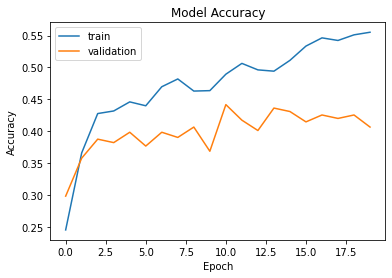

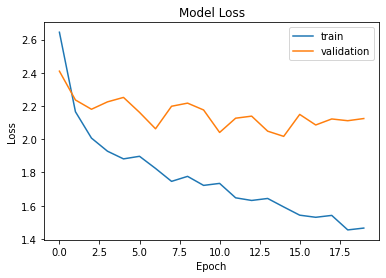

In [105]:
history_dict = {}

for key, value in model_dict.items():
    if key == 'vgg_16':
        value.compile(optimizer="rmsprop", loss="categorical_crossentropy", metrics=["accuracy"])
    else:
        value.compile(optimizer=Adam(learning_rate=learning_rate), loss="categorical_crossentropy", metrics=["accuracy"])

    early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
    reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

    history = value.fit(
        train_generator,
        epochs=epochs,
        validation_data=val_generator,
        callbacks=[early_stop, reduce_lr],
    )

    history_dict[key] = history

    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

    # plot training and validation loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.show()

Accuracy of 33.41%
Accuracy of 13.02%
Accuracy of 9.98%
Accuracy of 13.23%


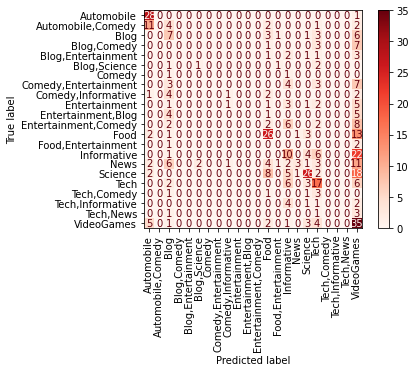

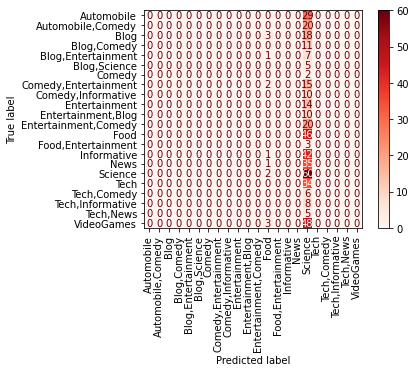

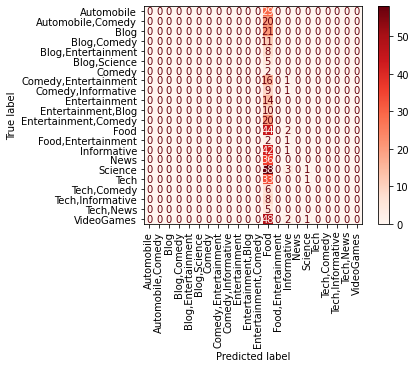

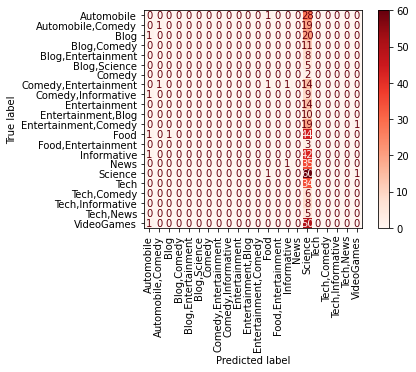

In [109]:
for key, value in model_dict.items():
    pred = value.predict(x_test)
    predictions = np.argmax(pred, axis=1)
    cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
    acc = accuracy_score(np.argmax(y_test, axis=1), predictions)
    print(f"Accuracy of {round(acc*100, 2)}%")
    cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
    cm_display.plot(cmap="Reds", xticks_rotation=90)

## Grid Search for Custom CNN

In [59]:
def create_custom_cnn(n_filter_1, n_filter_2, kernel_size, pool_size, n_hidden):
    model = Sequential()
    model.add(Conv2D(n_filter_1, kernel_size=kernel_size, activation="relu", input_shape=target_size+(3,)))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Conv2D(n_filter_2, kernel_size=kernel_size, activation="relu"))
    model.add(MaxPooling2D(pool_size=pool_size))
    model.add(Flatten())
    model.add(Dense(n_hidden, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(len(le.classes_), activation="softmax"))
    model.compile(optimizer=Adam(learning_rate=1e-03), loss="categorical_crossentropy", metrics=["accuracy"])
    return model

In [60]:
model = KerasClassifier(build_fn=create_custom_cnn)
param_grid = {
    'n_filter_1': [16, 32, 64],
    'n_filter_2': [16, 32, 64],
    'kernel_size': [3, 5],
    'pool_size': [2, 3],
    'n_hidden': [64, 128]
}
grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=3, verbose=3)
grid_result = grid.fit(x_train, y_train, epochs=10, validation_data=(x_test, y_test), callbacks=[early_stop, reduce_lr])

print(f'Best Parameters: {grid_result.best_params_}')
print(f'Best Accuracy: {grid_result.best_score_:.2f}')

c:\Users\Dominik Hahn\Anaconda3\envs\deep_learning\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: KerasClassifier is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead.
  """Entry point for launching an IPython kernel.


Fitting 3 folds for each of 72 candidates, totalling 216 fits
Epoch 1/10
39/39 [==============================] - 1s 13ms/step - loss: 96.6606 - accuracy: 0.0733 - val_loss: 3.1040 - val_accuracy: 0.1258 - lr: 0.0010
Epoch 2/10
39/39 [==============================] - 0s 10ms/step - loss: 3.0882 - accuracy: 0.1132 - val_loss: 3.0585 - val_accuracy: 0.1367 - lr: 0.0010
Epoch 3/10
39/39 [==============================] - 0s 10ms/step - loss: 3.0647 - accuracy: 0.1238 - val_loss: 3.0420 - val_accuracy: 0.1345 - lr: 0.0010
Epoch 4/10
39/39 [==============================] - 0s 10ms/step - loss: 3.0285 - accuracy: 0.1238 - val_loss: 3.0273 - val_accuracy: 0.1345 - lr: 0.0010
Epoch 5/10
39/39 [==============================] - 0s 10ms/step - loss: 3.0057 - accuracy: 0.1254 - val_loss: 3.0132 - val_accuracy: 0.1345 - lr: 0.0010
Epoch 6/10
39/39 [==============================] - 0s 10ms/step - loss: 2.9886 - accuracy: 0.1156 - val_loss: 2.9997 - val_accuracy: 0.1323 - lr: 0.0010
Epoch 7/10
39

# Training of best CNN based on Grid Search

In [57]:
# Best Parameters: {'kernel_size': 3, 'n_filter_1': 32, 'n_filter_2': 64, 'n_hidden': 128, 'pool_size': 3}

custom_model = Sequential()
custom_model.add(Conv2D(32, kernel_size=3, activation="relu", input_shape=target_size+(3,)))
custom_model.add(MaxPooling2D(pool_size=3))
custom_model.add(Conv2D(64, kernel_size=3, activation="relu"))
custom_model.add(MaxPooling2D(pool_size=3))
custom_model.add(Flatten())
custom_model.add(Dense(128, activation="relu"))
custom_model.add(Dropout(0.3))
custom_model.add(Dense(len(le.classes_), activation="softmax"))

custom_model.compile(optimizer=Adam(learning_rate=1e-03), loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/100
47/47 [==============================] - 9s 169ms/step - loss: 2.8949 - accuracy: 0.1208 - val_loss: 2.7390 - val_accuracy: 0.1572 - lr: 0.0010
Epoch 2/100
47/47 [==============================] - 8s 167ms/step - loss: 2.6092 - accuracy: 0.2003 - val_loss: 2.5474 - val_accuracy: 0.2385 - lr: 0.0010
Epoch 3/100
47/47 [==============================] - 8s 167ms/step - loss: 2.3929 - accuracy: 0.2831 - val_loss: 2.4539 - val_accuracy: 0.2927 - lr: 0.0010
Epoch 4/100
47/47 [==============================] - 8s 167ms/step - loss: 2.2286 - accuracy: 0.3313 - val_loss: 2.3183 - val_accuracy: 0.3631 - lr: 0.0010
Epoch 5/100
47/47 [==============================] - 8s 167ms/step - loss: 2.0784 - accuracy: 0.3578 - val_loss: 2.5738 - val_accuracy: 0.2900 - lr: 0.0010
Epoch 6/100
47/47 [==============================] - 8s 168ms/step - loss: 2.0039 - accuracy: 0.3815 - val_loss: 2.2669 - val_accuracy: 0.3957 - lr: 0.0010
Epoch 7/100
47/47 [==============================] - 8s 168ms/st

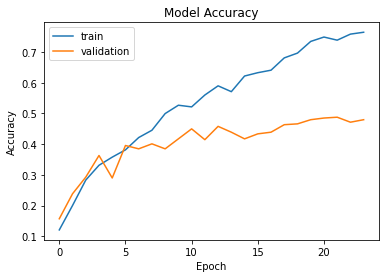

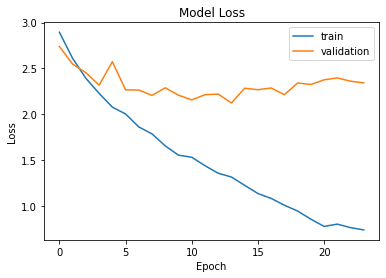

In [58]:
early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5)

history = custom_model.fit(
    train_generator,
    epochs=100,
    validation_data=val_generator,
    callbacks=[early_stop, reduce_lr],
)

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# plot training and validation loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

Accuracy of 41.65%


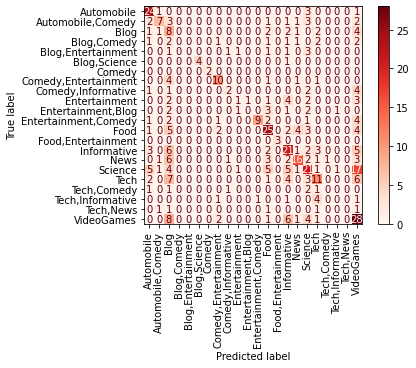

In [110]:
pred = custom_model.predict(x_test)
predictions = np.argmax(pred, axis=1)
cm = confusion_matrix(np.argmax(y_test, axis=1), predictions)
acc = accuracy_score(np.argmax(y_test, axis=1), predictions)
print(f"Accuracy of {round(acc*100, 2)}%")
cm_display = ConfusionMatrixDisplay(cm, display_labels=le.classes_)
cm_display.plot(cmap="Reds", xticks_rotation=90)

# Plot Model

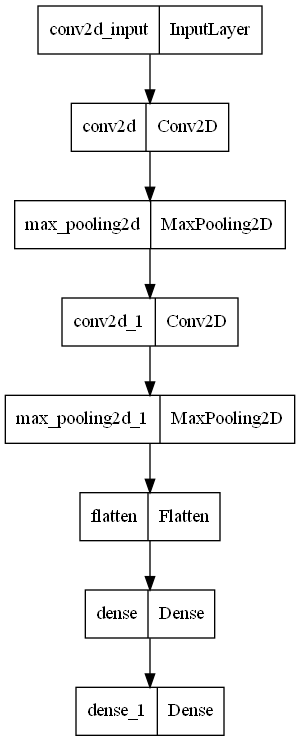

In [26]:
plot_model(model)

In [22]:
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 111, 111, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 186624)            0         
                                                                 
 dense (Dense)               (None, 128)               2

In [25]:
from keras.utils.vis_utils import model_to_dot

dot = model_to_dot(model, show_shapes=True, show_layer_names=True)
dot.set_rankdir('LR')
dot.set_splines('ortho')
dot.set_node_defaults(fontsize='12', fontname='Arial')
dot.set_edge_defaults(fontsize='10', fontname='Arial')
dot.write_svg('model.svg')

# Grad Cam